# Data Science 1 - Signal analysis

## Lesson 5 - Applications of the Fourier transform

&copy; 2021, dr.ir. Dave R.M. Langers (LADR, ZP11/H1.90, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl))

<img src="https://bioinf.nl/~davelangers/dave.png" width="10%" height="10%" alt="Dave Langers" /> 

<small>**Note:** step forward using `SPACE` or backward using `SHIFT`+`SPACE`, or use the arrows in the bottom right to navigate; run code cells using `CTRL`+`ENTER`.</small>

In [14]:
# Initialization

%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from scipy import signal
from IPython.display import display
from lesson5 import figure

### Main material

*Hands-on Signal Analysis with Python: An Introduction*, **chapter 9.1, 9.3.1-2, 9.4, 9.7**

<img src="https://images-na.ssl-images-amazon.com/images/I/41CaMa-FgDS._SX375_BO1,204,203,200_.jpg" width="5%" height="5%" alt="Hands-on Signal Analysis with Python: An Introduction" />

### <a id="/1">Lesson 5 - Applications of the Fourier transform</a>

* <u>Part 5A</u><br />*Fourier filtering*

* <span style="color:#336699"><a href="#/7">Part 5B</a><br />Fourier interpolation</span>

### Inverse Fourier transform

Some operations are most easily carried out in the [time domain](https://en.wikipedia.org/wiki/Time_domain). For example:

* extending a signal by zero-padding, or by repeating it multiple times

* cutting away localized [artifacts](https://en.wikipedia.org/wiki/Artifact_(error)), like spikes

* multiplying a signal with a window

* determining minima or maxima

However, other operations prove to be simpler in the [frequency domain](https://en.wikipedia.org/wiki/Frequency_domain). For example:

* interpolation of intermediate values

* removing periodic [artifacts](https://en.wikipedia.org/wiki/Artifact_(error)), like 50-Hz power line interference

* smoothing to remove signal noise, or other types of filtering

* determining the frequency of a quasi-periodic signal

For this reason, it is convenient to be able to transform a signal from the time domain into the frequency domain, and to transform a spectrum from the frequency domain back into the time domain.

### Filtering

A [filter](https://en.wikipedia.org/wiki/Filter_(signal_processing)) consists of a function that removes unwanted features from a signal.

Many filters act in the frequency domain and are characterized by their [frequecny response](https://en.wikipedia.org/wiki/Frequency_response). They can be seen as a multiplication of the spectrum by a [transfer function](https://en.wikipedia.org/wiki/Transfer_function). That is, the amplitude of every frequency component is multiplied by some frequency-dependent value $T(f)$.

$$
A'(f) = T(f) \cdot A(f)
$$

As a rule of thumb:

* for frequencies that are relevant, set $T(f)$ = 1

* for frequencies that are unwanted, set $T(f)$ = 0

Common types of filters let through certain frequency ranges and block others.

* A [low-pass filter](https://en.wikipedia.org/wiki/Low-pass_filter) has $T(f)=1$ for $f<f_\text{max}$, and $T(f)=0$ otherwise.<br />
  This filter can for instance be used to let through a coherently varying signal, while blocking most [white noise](https://en.wikipedia.org/wiki/) at high frequencies.
  
* A [high-pass filter](https://en.wikipedia.org/wiki/High-pass_filter) filter has $T(f)=1$ for $f>f_\text{min}$, and $T(f)=0$ otherwise.<br />
  This filter can for instance be used to let through fluctuating signals, while blocking slow drift.
  
[Band-pass filters](https://en.wikipedia.org/wiki/Band-pass_filter) and [band-stop filters](https://en.wikipedia.org/wiki/Band-stop_filter) combine these ideas, by letting through or blocking frequencies in an interval $f_\text{min}<f<f_\text{max}$, respectively.

The figure illustrates an artificial signal that consists of a sinusoid with frequency $f=1$, plus some random noise.

The spectrum shows a strong peak at $f=1$, and weaker but non-zero amplitudes at all other frequencies.

We wish to "clean up" the signal and remove the noise, whilst still retaining the sinusoidal signal. This is not trivial to achieve in the time domain, but it is easy in the frequency domain.

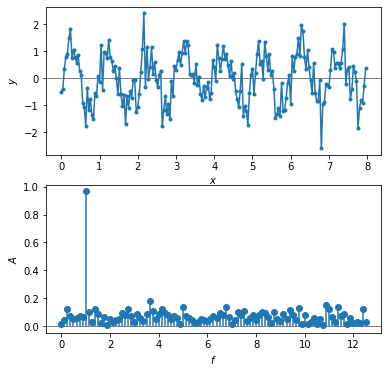

Figure 1: Signal & Spectrum


In [2]:
figure(1)

Because we know that we are interested in oscillations at $f=1$, we define a transfer function $T(f)$ that equals 1 for $f=1$, and 0 otherwise.

When we multiply the frequency spectrum by this transfer function, only the peak "survives".

Transform the spectrum back into the time domain, we obtain a clean signal that matches the original signal not only in frequency, but also in phase and amplitude.

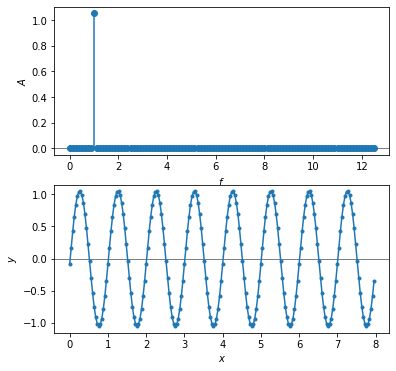

Figure 2: Spectrum & Signal


In [3]:
figure(2)

### Example

Consider the following data regarding the average temperature in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)).

| Month     | T [°C] |   | Month     | T [°C] |
| --------- | ------ | - | --------- | ------ |
| January   |  2.5   |   | July      | 17.5   |
| February  |  2.9   |   | August    | 17.2   |
| March     |  5.5   |   | September | 14.2   |
| April     |  8.9   |   | October   | 10.2   |
| May       | 12.4   |   | November  |  6.1   |
| June      | 15.1   |   | December  |  3.3   |

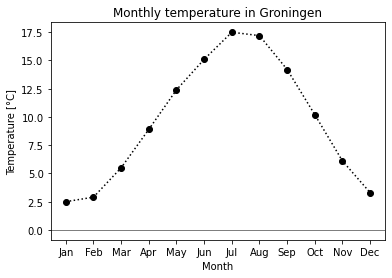

In [4]:
from calendar import month_abbr
months = [month_abbr[i + 1] for i in range(12)]
temps = np.array([2.5,  2.9,  5.5,  8.9,  12.4, 15.1,
                  17.5, 17.2, 14.2, 10.2, 6.1,  3.3])

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:k')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.xticks(range(12), months)
plt.show()

We can transform these data into a spectrum using the code from the previous lesson.

The first two frequency components can be interpreted meaningfully; the other much weaker components may be attributed to random effects.

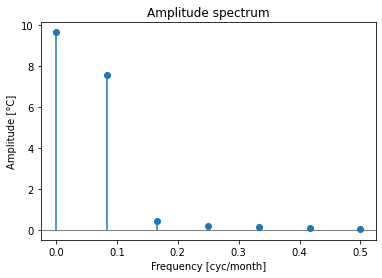

In [5]:
coef = np.fft.rfft(temps, norm='forward')
coef[1:-1] = 2.0 * np.conj(coef[1:-1])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a * a + b * b)
f = np.fft.rfftfreq(temps.size, 1.0)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

Suppose we wish to remove the contribution of the higher frequency components. In the frequency domain, we can define a transfer function that achieves this.

We filter the original signal using a low-pass filter that only lets through the frequencies below a certain cut-off, here e.g. $f_\text{max} \approx 0.1$ cyc/month.

The transfer function is applied to both the cosine and sine coefficients $a$ and $b$.

<small>**Note:** we could also write `a *= (f < 0.1); b *= (f < 0.1)`.</small>

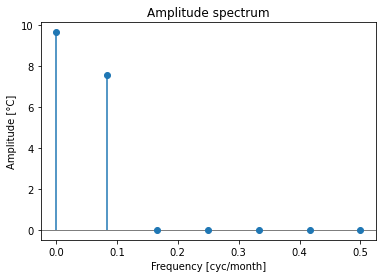

In [6]:
transfer = np.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
a *= transfer
b *= transfer
spectrum = np.sqrt(a * a + b * b)
f = np.fft.rfftfreq(temps.size, 1.0)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

We can subsequently use the *inverse* (real-valued, fast) Fourier transform `irfft()` from the `np.fft` module to reconstruct the original signal.

Because the number of components in the spectrum is approximately half as small as the number of samples in the signal, there is ambiguity in the size of the signal that needs to be reconstructed. Be aware that `irfft()` by default assumes the required number of samples $n$ is even; if it is odd, it needs to be specified as an extra argument `irfft(coef, n)`.

In [7]:
help(np.fft.irfft)

Help on function irfft in module numpy.fft:

irfft(a, n=None, axis=-1, norm=None)
    Computes the inverse of `rfft`.
    
    This function computes the inverse of the one-dimensional *n*-point
    discrete Fourier Transform of real input computed by `rfft`.
    In other words, ``irfft(rfft(a), len(a)) == a`` to within numerical
    accuracy. (See Notes below for why ``len(a)`` is necessary here.)
    
    The input is expected to be in the form returned by `rfft`, i.e. the
    real zero-frequency term followed by the complex positive frequency terms
    in order of increasing frequency.  Since the discrete Fourier Transform of
    real input is Hermitian-symmetric, the negative frequency terms are taken
    to be the complex conjugates of the corresponding positive frequency terms.
    
    Parameters
    ----------
    a : array_like
        The input array.
    n : int, optional
        Length of the transformed axis of the output.
        For `n` output points, ``n//2+1`` input po

However, before we can use the inverse Fourier transform, we need to combine `a` and `b` back into a single complex spectrum.

In [8]:
coef = a + 1j * b

Moreover, we need to "undo" the multiplication by a factor 2 of all frequencies except the zero and Nyquist frequency, and the flip of the imaginary component.

In [9]:
coef[1:-1] = 0.5 * np.conj(coef[1:-1])

Now we can invert the Fourier transform.

Since we used the `norm='forward'` argument when determining the Fourier transform, this needs to be specified to the `irfft()` function as well.

<small>**Note:** for this example, the result is a pure sinusoid, equivalent to applying the `trig_curvefit()` function from the previous lesson.</small>

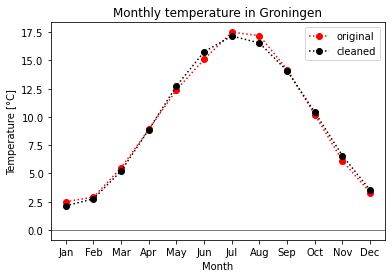

In [10]:
cleaned = np.fft.irfft(coef, norm='forward')

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:r', label='original')
plt.plot(cleaned, 'o:k', label='cleaned')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.legend(); plt.xticks(range(12), months)
plt.show()

### Other useful functions

The `scipy.fft` module contains an `irfft()` function that operates identically to that from `numpy`, but provides a couple of additional options. We will not make use of these, so for our purposes these functions are equivalent.

Similarly, `scipy.fft` supplies the `idct()` function that inverts the discrete cosine transform that we considered in lesson 4, part D. Like the `dct()` function, it allows the `type=1` parameter to be passed.</small>

### Exercise 1

Generate an artificial 4-second signal that contains a square wave of frequency $f=1$ Hz, sampled with a sampling frequency of 50 Hz. Apply a low-pass filter and vary the cutoff $f_\text{max}$. What does the resulting signal look like in the time domain?

In [70]:
def square(t):
    return np.sign(np.sin(2*np.pi*f*(t + 0.25)))

def low_pass_filter(a, f, fmax):
    return a  * (f < fmax)

In [98]:
L = 4 # 4 seconds
f = 1
fs = 50
ts = L / 200

x = np.linspace(0, 4, 200, endpoint=False)
y = square(x)

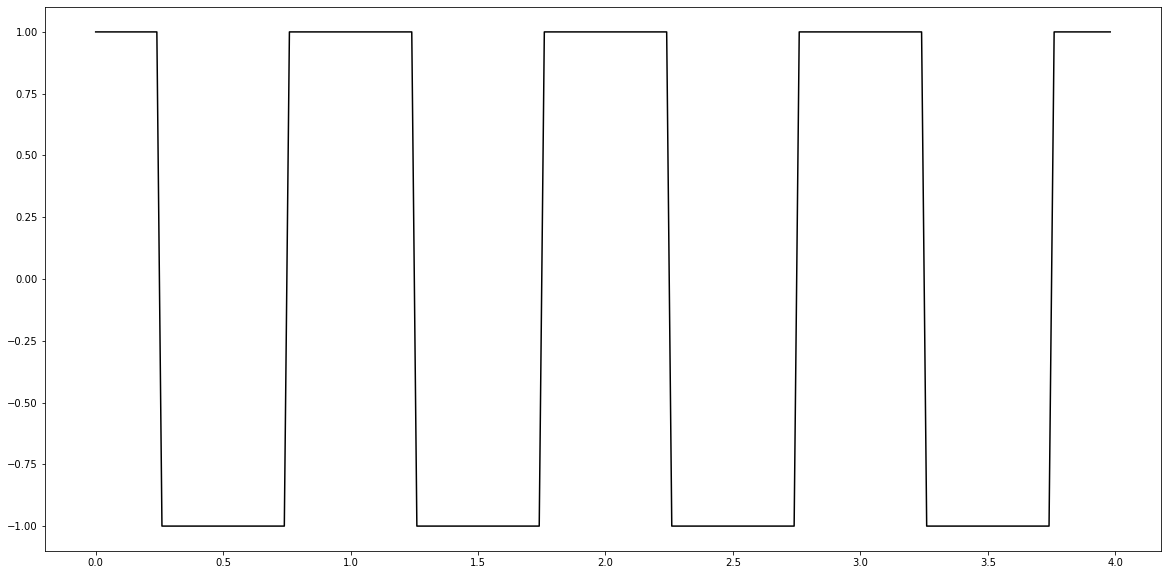

In [99]:
plt.figure(figsize=(20, 10))

plt.plot(x, y, color='black')
plt.show()

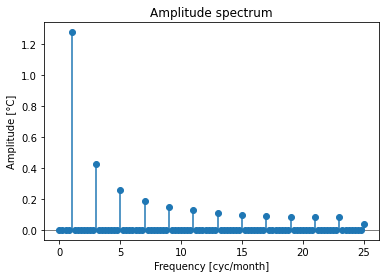

In [100]:
# convert to frequency domain
coef = np.fft.rfft(y, norm='forward')
coef[1:-1] = 2.0 * np.conj(coef[1:-1])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a**2 + b**2)
f = np.fft.rfftfreq(y.size, ts)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

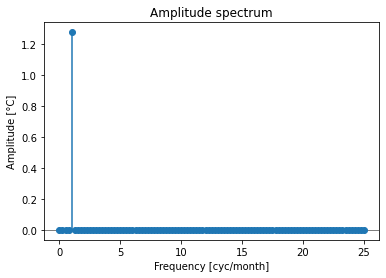

In [101]:
# apply filtering
a *= (f < 2)
b *= (f < 2)

spectrum = np.sqrt(a**2 + b**2)
f = np.fft.rfftfreq(y.size, ts)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

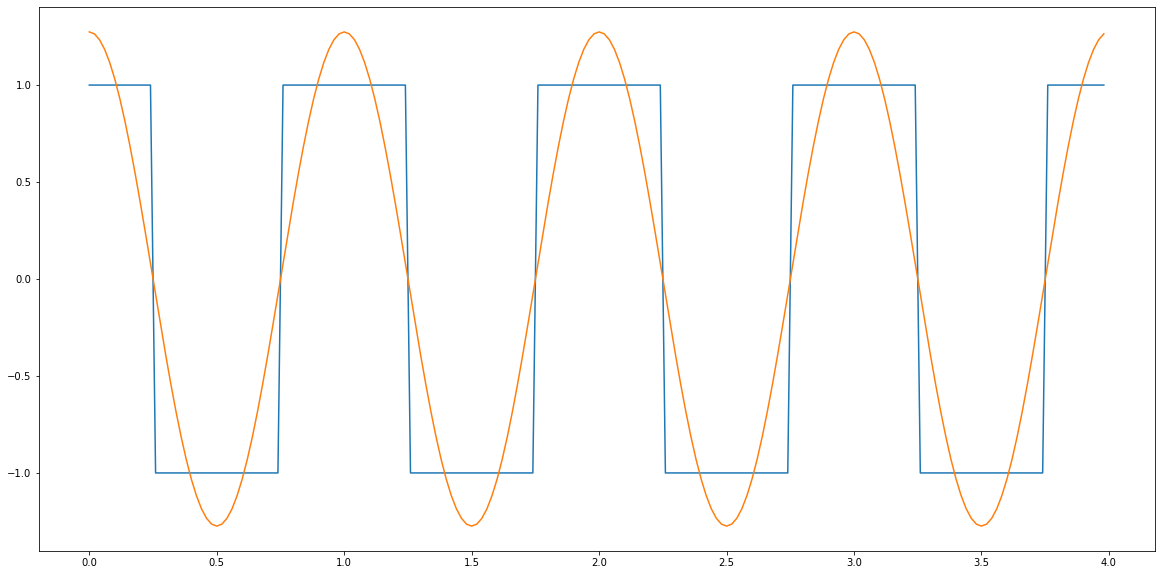

In [105]:
# Inverse
coef = a + 1j * b
coef[1:-1] = 0.5 * np.conj(coef[1:-1])

cleaned = np.fft.irfft(coef, norm='forward')

plt.figure(figsize=(20, 10))

plt.plot(x, y)
plt.plot(x, cleaned)
plt.show()

A low-pass filter has 𝑇(𝑓)=1 for 𝑓<𝑓max, and 𝑇(𝑓)=0 otherwise.

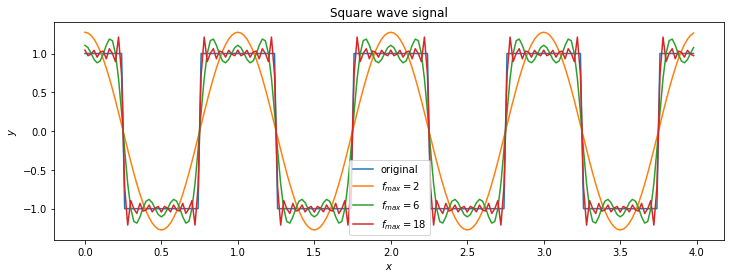

### Exercise 2

The below code fragment loads the respiratory volume of a subject while standing breathing normally (first half minute) or breathing deeply (second half minute) according to a sensor placed around the thorax (from: [biosignalsplux](https://biosignalsplux.com/learn/samples.html)).

```python
url = 'http://biosignalsplux.com/downloads/samples/respiration-rip/SampleRIP_converted.txt'
respiration = pd.read_csv(url, sep='\t', dtype=float, comment='#',
              usecols=[0, 2], names=['Time [s]', 'Volume [L]']).loc[::100, :]
respiration['Time [s]'] = respiration['Time [s]'] * 1e-3
```

Filter this signal using a band-pass filter with cutoff frequencies $f_\text{min}=10$ cyc/min and $f_\text{max}=20$ cyc/min.

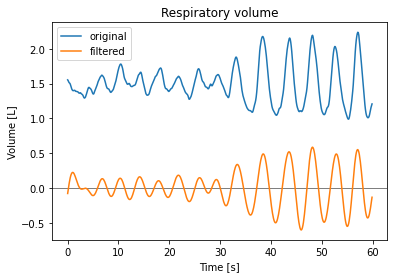

### Exercise 3

The following code downloads an electrocardiographic (ECG) signal that was recorded at a sampling rate of 500 Hz in a [telehealth environment](https://en.wikipedia.org/wiki/Telehealth) from two electrodes held in the left and right hand (from: [Khamis et al., Harvard dataverse](https://doi.org/10.7910/DVN/QTG0EP)).

```python
import requests, io
url = 'https://dataverse.harvard.edu/api/access/datafile/:' + \
      'persistentId?persistentId=doi:10.7910/DVN/QTG0EP/IW7ADN'
ecg = pd.read_csv(io.StringIO(requests.get(url).text),
                  usecols=[0], names=['Potential [mV]'])
```

Upon close visual inspection of the signal and its spectrum, the data can be seen to contain oscillations related to the heart beat, but also slow baseline drift (especially in the first half of the measurement) and a substantial artifact at 50 Hz caused by interference from [mains power](https://en.wikipedia.org/wiki/Utility_frequency).

Inspect the signal spectrum to design and apply a filter with a transfer function that removes the 50-Hz artifact as well as the drifting baseline.

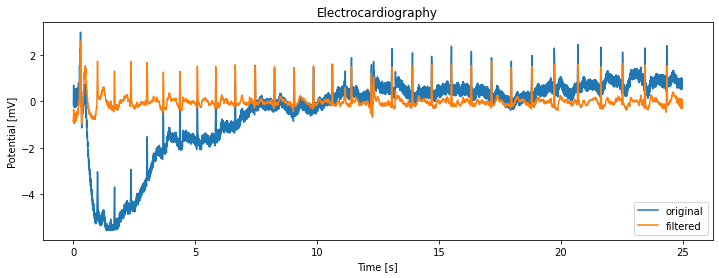

### Exercise 4

The following code loads information regarding the water level as measured at 10-minute intervals in Lauwersoog (Groningen, NL) over the past 4 weeks (from: [Rijkswaterstaat](https://rijkswaterstaatdata.nl)).

```python
url = 'https://waterinfo.rws.nl/api/Download/CSV?expertParameter=' + \
      'Waterhoogte%20Oppervlaktewater%20t.o.v.%20Normaal%20Amsterdams%20Peil%20in%20cm' + \
      '&locationSlug=Lauwersoog(LAUW)&timehorizon=-672,0'
tides = pd.read_csv(url, sep=';', header=0, usecols=[0, 1, 4],
                    names=['Date', 'Time', 'Water level [cm NAP]']).dropna()
```

Split this signal into two constituent parts, one containing all the frequencies up to 1.5 cycle per day, and another containing all the frequencies exceeding 1.5 cycle per day. Use the *discrete cosine transform* to achieve this.

What is your interpretation of the separate parts?

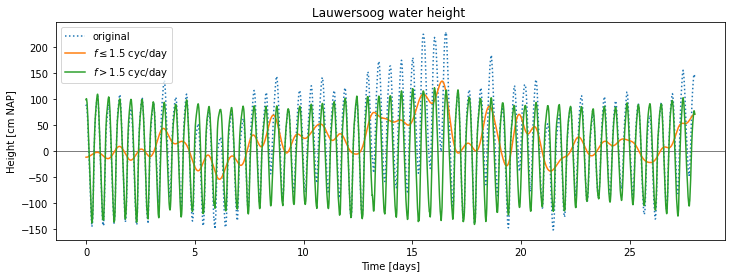

### Exercise 5

The following code loads the daily percentage sunshine that was measured across the last four years in Eelde (Groningen, NL).

```python
url = 'https://daggegevens.knmi.nl/klimatologie/daggegevens?' + \
      'start=20180101&end=20211231&stns[280]=1&vars[SP]=1'
sun = pd.read_csv(url, comment='#', usecols=[1, 2], names=['Day', 'Sunshine [%]'])
```

Filter this signal using a transfer function that is zero everywhere, except for frequencies that are an exact multiple of 1 cyc/yr, but not exceeding 5 cyc/yr. Decide for yourself whether the *discrete Fourier transform* or the *discrete cosine transform* is more natural to use here.

What is the effect of only letting through frequencies that do not exceed 5 cyc/yr? And what is the effect of only letting through frequencies that are multiples of 1 cyc/yr?

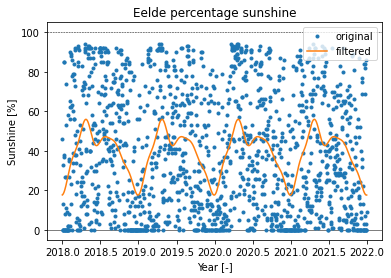

### <a id="/7">Lesson 5 - Applications of the Fourier transform</a>

* <span style="color:#336699"><a href="#/1">Part 5A</a><br />Fourier filtering</span>

* <u>Part 5B</u><br />*Fourier interpolation*

### Time-frequency duality

In the previous lesson, we saw that the range of frequencies in a signal's spectrum, bounded by the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) $f_\text{Ny}$, is determined by the sampling resolution in time, i.e. the sampling time $t_s$.

$$
f_\text{Ny} = \frac{1}{2t_s}
$$

Therefore:

* A *denser* sampling corresponds with a more *extensive* spectrum

<small>**Note:** in the limit, a *continuous* signal corresponds with an *infinite* spectrum.</small>

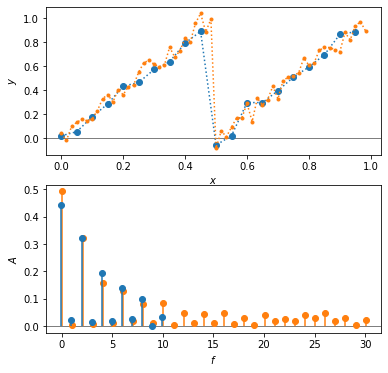

Figure 3: Signals & Spectra


In [16]:
figure(3)

The lowest non-zero frequency always corresponds with one cycle across the entire signal, i.e. $f_1=\frac{1}{L}$. Therefore, also the separation between neighboring frequency components equals $\Delta f=\frac{1}{L}$.

In other words, the duration of the signal $L$ is related to the frequency separation $\Delta f$ according to

$$
L = \frac{1}{\Delta f}
$$

Therefore:

* A more *extensive* sampling corresponds with a *denser* spectrum

<small>**Note:** in the limit, an *infinite* signal corresponds with a *continuous* spectrum.</small>

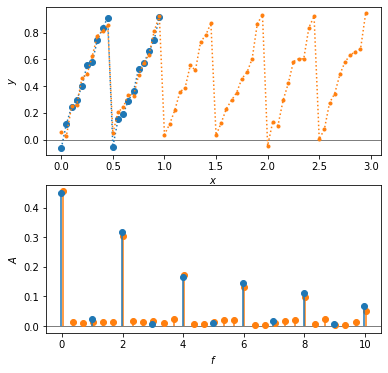

Figure 4: Signals & Spectra


In [17]:
figure(4)

In summary, there is a duality between the time and frequency domains:

* Temporal resolution relates to spectral extent

$$
t_s \cdot f_\text{Ny} = \frac{1}{2}
$$

* Spectral resolution relates to temporal extent

$$
\Delta f \cdot L = 1
$$

### Fourier interpolation

Interpolation consists of the estimation of signal values $y(x)$ at $x$ that are intermediate between measurements.

When working with equidistant samples, interpolation consists of increasing the temporal resolution of a signal. This is also known as [upsampling](https://en.wikipedia.org/wiki/Upsampling).

Given the time-frequency duality, this amounts to extending the frequency range of the spectrum.

Since no information is available about signal components above the Nyquist-frequency, the most natural approach is to pad the spectrum with zeros.

<small>**Note:** similarly, decreasing the sampling frequency is known as [downsampling](https://en.wikipedia.org/wiki/Downsampling), which can be achieved by entirely removing the highest frequency components from the signal's spectrum (as opposed to merely setting them equal to zero when low-pass filtering).</small>

The illustration shows that when the spectrum is extended with zeros, the signal in the time domain is interpolated.

If the upsampling is carried out by an integer factor, the original data should be reproduced exactly.

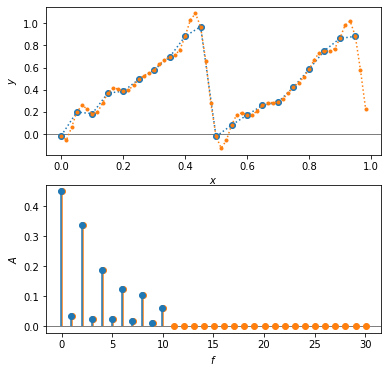

Figure 5: FFT interpolation


In [18]:
figure(5)

The same can be achieved with the type-I discrete cosine transform.

The result differs from the discrete Fourier transform in its assumptions about the boundary condition: Fourier transforms assume that a signal wraps around, whereas the cosine transform assumes the signal is extended by reflection.

<small>**Note:** some accurate bookkeeping is required if the signal needs to be upsampled by an integer factor without extrapolating beyond the boundary points.</small>

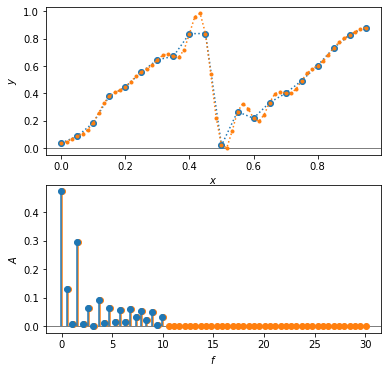

Figure 6: DCT interpolation


In [19]:
figure(6)

### Example

Again, consider the following data regarding the average temperature in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)).

| Month     | T [°C] |   | Month     | T [°C] |
| --------- | ------ | - | --------- | ------ |
| January   |  2.5   |   | July      | 17.5   |
| February  |  2.9   |   | August    | 17.2   |
| March     |  5.5   |   | September | 14.2   |
| April     |  8.9   |   | October   | 10.2   |
| May       | 12.4   |   | November  |  6.1   |
| June      | 15.1   |   | December  |  3.3   |

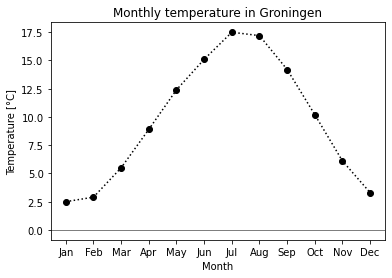

In [20]:
from calendar import month_abbr
months = [month_abbr[i + 1] for i in range(12)]
temps = np.array([2.5,  2.9,  5.5,  8.9,  12.4, 15.1,
                  17.5, 17.2, 14.2, 10.2, 6.1,  3.3])

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:k')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.xticks(range(12), months)
plt.show()

We wish to interpolate the signal, upsampling it by a factor four, thus obtaining approximately the weekly instead of monthly temperature.

First, we transform the signal into its spectrum again.

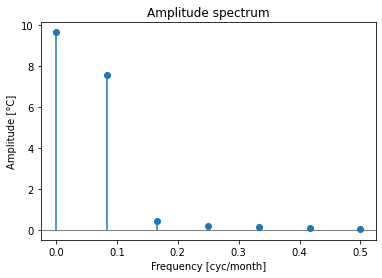

In [21]:
coef = np.fft.rfft(temps, norm='forward')
coef[1:-1] = 2.0 * np.conj(coef[1:-1])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a * a + b * b)
f = np.fft.rfftfreq(temps.size, 1.0)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

The current Nyquist frequency equals $f_\text{Ny} = \frac{1}{2}$ cyc/month.

We wish to upsample to four times the temporal resolution, so the desired Nyquist frequency equals $f_\text{Ny} = 2$ cyc/month.

The separation between frequency components is $\frac{1}{L} = \frac{1}{12}$ cyc/month.

Therefore, we need to add

$$
\frac{2-\frac{1}{2}}{\frac{1}{12}} = 18
$$

additional frequency components.

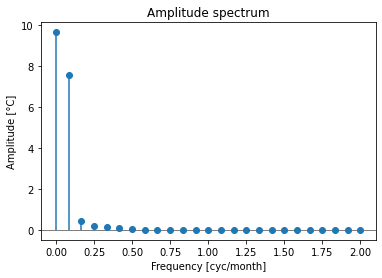

In [22]:
a = np.concatenate((a, np.zeros(18)))
b = np.concatenate((b, np.zeros(18)))
spectrum = np.sqrt(a * a + b * b)
f = np.fft.rfftfreq(4 * temps.size, 0.25)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

We can subsequently use the `irfft()` function to reconstruct the corresponding signal.

<small>**Note:** although not strictly necessary here because the signal length is even, in the example the number of required samples is passed as an argument to the `irfft()` function.</small>

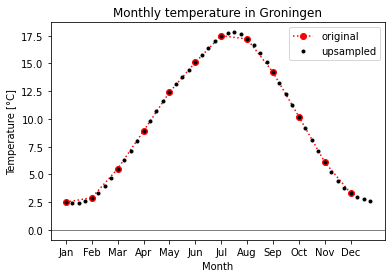

In [23]:
coef = a + 1j * b
coef[1:-1] = 0.5 * np.conj(coef[1:-1])
x = np.arange(48) / 4.0
y = np.fft.irfft(coef, 48, norm='forward')

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:r', label='original')
plt.plot(x, y, '.k', label='upsampled')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.legend(); plt.xticks(range(12), months)
plt.show()

### Other useful functions

The `scipy.signal` module contains a `resample()` function that performs resampling based on Fourier interpolation. As arguments, it requires the original data as well as the number of desired datapoints.

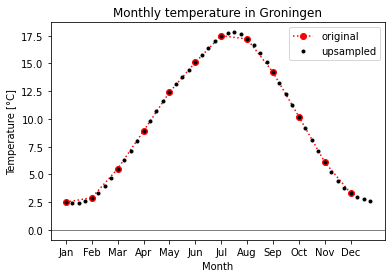

In [24]:
from scipy.signal import resample
y = resample(temps, 48)

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:r', label='original')
plt.plot(x, y, '.k', label='upsampled')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.legend(); plt.xticks(range(12), months)
plt.show()

### Exercise 6

Upsample the temperature data by a factor of four using the *discrete cosine transform* instead of the *discrete Fourier transform*. Compare the result to the previous example, and explain any differences you observe.

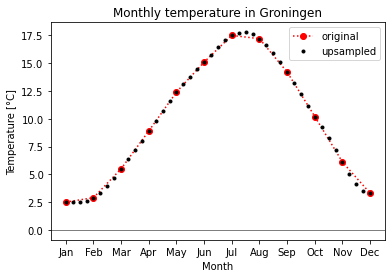

### Exercise 7

Complete the below skeleton function `fourier_resample()` that resamples a specified regularly sampled signal `yi` using Fourier interpolation. The user supplies the desired number of samples `n` in the signal as a required argument.

* If `n` is larger than the size of `yi`, pad the spectrum with zeros

* If `n` is smaller than the size of `yi`, crop the spectrum to a shorter extent.

<small>**Note:** Write your own code that implements the described approach; the use of the `rfft()` and `irfft()` functions from `numpy.fft` or `scipy.fft` is permitted, but do *not* simply wrap the `resample()` function that `scipy` provides!</small>


```python
def fourier_resample(yi, n):
    """y = fourier_resample(yi, n).
    Fourier interpolation method that resamples a given
    signal yi to n new points. The first element of the
    returned signal y coincides with the first element
    of the provided signal yi.
    yi     = {y1,y2,...,xn}
    n      = desired number of points
    """
    pass   # ADD YOUR OWN CODE HERE
    return y
```

### Exercise 8

Generate an artificial 4-second signal that contains a square wave of frequency $f=1$ Hz, sampled with a sampling frequency of 10 Hz.

Plot the signal, together with a signal that has been upsampled by a factor of five using your `fourier_resample()` function, and verify that the interpolated signal coincides with the original signal where those original samples are available.

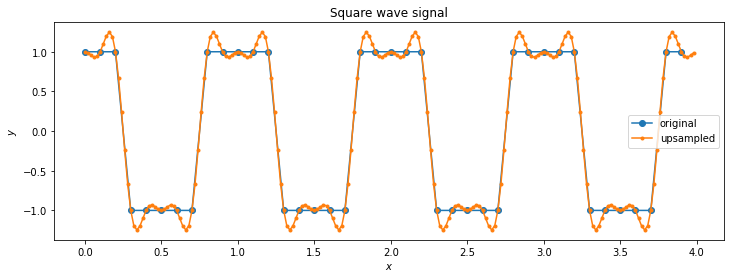

### Exercise 9

Consider the following data regarding the average amount of precipitation in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)).

| Month     | P [mm] |   | Month     | P [mm] |
| --------- | ------ | - | --------- | ------ |
| January   |   75   |   | July      |   85   |
| February  |   50   |   | August    |   80   |
| March     |   55   |   | September |   75   |
| April     |   45   |   | October   |   70   |
| May       |   60   |   | November  |   70   |
| June      |   65   |   | December  |   80   |

Plot these data together with versions that have been up- or downsampled using your `fourier_resample()` function to 6, 12, and 36 samples, respectively.

Does the resampled signal always reproduce the original data whenever the $x$-values coincide?

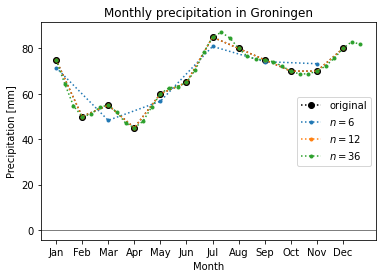

<div class="alert alert-block alert-danger">This notebook is incomplete. Please see Blackboard for a full version that includes parts C & D!</div>

***